In [121]:
# !pip install numpy
# ! pip install deap

# The class for reading the knapsack dataset file.

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from distutils.command.build_scripts import first_line_re
from tkinter.tix import COLUMN
# Import deque for the stack structure, copy for deep copy nodes
from collections import deque

class Knapsack:
    '''For each instance, we have following fields: 
            the 1st line of the  file contains the number of items N and the knapsack capacity C.,
            2nd onwards contains the Value and Weight of each item, separated by a space.
    '''
    # main constructor 
    def __init__(self, M, capacity, items):
        '''M is the number of items, i.e. len(items)'''
        self.M = M
        self.capacity = capacity
        self.items = items
        self.items_dict  = {}
        i = 0
        for x in self.items.to_records(index=False):
            self.items_dict[i] = tuple(x)
            i += 1
        
    @classmethod
    def constructFromFile(cls, filePath):
        '''Read from file and construct an instance of Knapsack'''
        with open(filePath, 'r') as file:
            first_line = file.readline()
            N,capacity = int(first_line.split(' ')[0]),int(first_line.split(' ')[1])
            # first_line = first_line.split(' ')
        itemsdf = pd.read_csv(filePath,delim_whitespace=True, skiprows=range(1), header=None)
        itemsdf.columns = ['Value', 'Weight']
        
        # add a index column for the items
        # items.index = items.index + 1
        return cls(N, capacity, itemsdf)
    
    def __str__(self):
        return 'N = {}, capacity = {}, \nitems =\n {}'.format(self.M, self.capacity, self.items)    
# ds_10_269 = Knapsack.constructFromFile('10_269')
# print(ten_269)
# len(ds_10_269.items)
    

# part 1 :

Develop a GA to solve the 0-1 knapsack problem and apply it to the provided three instances. You can use a library or write the program from scratch (GA is not hard to code). 
You should 

- Determine the proper individual representation and explain the reasons. 
- Design the proper fitness function and justify it. 
- Design proper crossover and mutation operators. 
- Set proper GA parameter values, such as population size, crossover and mutation rates, selection scheme. 
- For each instance, run the GA for 5 times with different random seeds. Present the mean and standard deviation of the GA in the 5 runs. 
- Compare the results with the optimal values, and make discussions. 
- Draw the convergence curve of the GA for each instance (x-axis being the number of generations, y-axis the average fitness of the 5 best solutions in the population of the xth generation from the 5 runs). Make discussions about the convergence curve and draw your conclusions.

First, define some hyper parameters for the GA.

In [2]:

# define some constants for the genetic algorithm
CONSTANTS_DICT = {
    "POPULATION_SIZE": 100, # number of individuals in each population
    "MAX_GENERATIONS": 250, # number of generations to run the algorithm
    "CROSSOVER_RATE": 1.0, # crossover rate should always be 100%, based on slides
    "MUTATION_RATE": 0.2, # mutation rate
    "ELITIST_PERCENTAGE": 0.05, # percentage of the best individuals to keep in the next generation
    
}


Then, use the creator to define the type of the individual and fitness classes

In [3]:
from asyncio import constants
from json import tool
from deap import creator, base, gp, tools, algorithms # core functionality of DEAP
import array
import random
import json
import math # for checking the fitness of an individual, i.e. math.isinf(weight)
import matplotlib.pyplot as plt
# Python internal operators for object comparisons, 
# logical comparisons, arithmetic operations, and sequence operations
import operator 


# creator is  usually used to define the type of the individual and fitness classes

# goal:to maximize the value and do not exceed the capacity of the knapsack
# define strategies with different priorities for optimizing multiple goals by using FitnessCompound
# 1 for maximize value, -1 for minimize weight, 
# creator.create("FitnessCompound", base.Fitness, weights=(1.0,-1.0)) 

# according to the evaluation function from the slide, 
# fitness value has been reduced to 1 dimension, so just use FitnessMax
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# Individual should be a list of binary values, i.e. a list of 0s and 1s
creator.create("Individual", list, fitness=creator.FitnessMax)


In [4]:
def evaluateFunction(ds: Knapsack, individual: creator.Individual, penality_coef: float):
    """fitness evaluation function for the knapsack problem.
    It is inspired by the slide and this paper
    :https://www.dataminingapps.com/2017/03/solving-the-knapsack-problem-with-a-simple-genetic-algorithm/ 

    Args:
        ds (Knapsack): for calculating value and weight
        individual (creator.Individual): a list of binary values, i.e. a list of 0s and 1s
        penality_coef (float): 
                        Very large value: always ignore infeasible solutions 
                        Zero: only consider quality (bad choice, will get 1111....1) 
                        Somewhere in between, parameter tuning, or adaptively change 𝛼

    Returns:
        tuple: the fitness of the individual
    """
    value, weight = 0.0, 0.0
    # calculate the value and weight of selected items for the given individual
    for i in range(len(individual)):
        value += ds.items.iloc[i]['Value'] * individual[i]
        weight += ds.items.iloc[i]['Weight'] * individual[i]
    penalty = penality_coef*max(0, weight - ds.capacity)
    fitnessVal = value-penalty

    return fitnessVal,

    # all_item_weight = ds.items['Weight'].sum()
    # penalty = abs(weight - ds.capacity) * all_item_weight
    # if weight > ds.capacity:
    #     return -math.inf, math.inf # ensure overweighted bags are dominated
    # return value, weight


def get_weight_value_attrs_for_given_individual(ds: Knapsack, individual: creator.Individual):
    """For recording statistics of the individual in order to plot the graph and print the statistics for each generation

    Args:
        ds (Knapsack): _description_
        individual (creator.Individual): _description_

    Returns:
        dict: for logbook to record the statistics of the individual
    """
    value, weight = 0.0, 0.0
    for i in range(len(individual)):
        value += ds.items.iloc[i]['Value'] * individual[i]
        weight += ds.items.iloc[i]['Weight'] * individual[i]
    # print(f"Individual: {individual}\nTotal value: {value} \n Total weight: {weight}")
    return {"best_ind_value": value, "best_ind_weight": weight, "best_ind_chromosome": individual}


In [5]:

# toolbox is a class contains the operators that we will use in our genetic programming algorithm
# it can be also be used as the container of methods which enables us to add new methods to the toolbox 
def setup_toolbox(ds:Knapsack,randSeed:int=12) -> base.Toolbox:
    toolbox = base.Toolbox()
    # for population size, we use the random.randint function to generate a random integer in the range [min, max]
    random.seed(randSeed)
    # register a method to generate random boolean values
    toolbox.register("attr_bool", random.randint, 0, 1)
    # register a method to generate random individuals
    toolbox.register("IndividualCreator", 
                     tools.initRepeat, 
                     creator.Individual, 
                     toolbox.attr_bool, 
                     n=len(ds.items)) 
    
    # N is not specificied, so need to specify number of individuals to generate within each population when we call it later
    toolbox.register("PopulationCreator", tools.initRepeat, list, toolbox.IndividualCreator) 
    
    # multi-objective problem, we have selected the NSGA-II selection scheme
    toolbox.register("elitism", tools.selBest, k=int(CONSTANTS_DICT["ELITIST_PERCENTAGE"]*ds.M))
    toolbox.register("select", tools.selTournament, k=2, tournsize=3)
    
    toolbox.register("mate", tools.cxTwoPoint) # TODO: might need to change this to cxOnePoint
    # indpb refer to the probability of mutate happening on each gene, it is NOT the same as mutation rate
    toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/ds.M) # TODO: might need to change this to mutUniformInt
    # local search operator
    # toolbox.register("local_search", algorithms)
    
    
    # register the evaluation function
    toolbox.register("evaluate", evaluateFunction,ds) # register a method to evaluate the fitness of an individual
    return toolbox

For GA framework implementation

In [6]:
import copy
from select import select
from turtle import update

def run_GA_framework(ds:Knapsack, max_gen= CONSTANTS_DICT["MAX_GENERATIONS"] ,randSeed:int=1) -> creator.Individual:
    '''
    Run the genetic algorithm framework
    '''
    # for toolbox
    random.seed(randSeed)
    toolbox = setup_toolbox(ds,randSeed)
    # for record keeping
    logbook = tools.Logbook()    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis = 0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)
    # stats.register("bestIndividualValue", calculate_weight_values, ds)
    
    # create the initial population
    population = toolbox.PopulationCreator(n=CONSTANTS_DICT["POPULATION_SIZE"])
    
    # Adaptive stargey for adjust the penalty coeff to the fitness function
    def calculate_penalty_coefficients(pop, penalty_coefficient_const, feasiible_percenttage_threshold) -> float:
        """COmpute penalty coefficients, if most  individuals are poor but feasible, decrease coeff
        If  most individuals have high value but infeasible, increase the penalty coefficient

        Returns:
            float: penalty coeff, the penalty coefficient for the fitness function
        """
        # compute the number of feasible individuals in the population
        feasible_count = 0
        for ind in pop:
            weight = get_weight_value_attrs_for_given_individual(ds,ind)['best_ind_weight']
            if weight <= ds.capacity:
                feasible_count += 1
        # compute the percentage of feasible individuals in the population
        feasible_percentage = feasible_count/len(pop)
        if feasible_percentage >= feasiible_percenttage_threshold:
            return penalty_coefficient_const * (1 + feasible_percentage )
        return penalty_coefficient_const * (1 - feasible_percentage)

        
    def evaluate_fitness_values(pop, penalty_coefficient_const = 666, feasiible_percenttage_threshold=0.5) -> None:
        """Update the fitness values of each individual for the given the population"""
        penalty_coefficient = calculate_penalty_coefficients(pop,
                                                                penalty_coefficient_const,
                                                                feasiible_percenttage_threshold)
        for ind in pop:
            ind.fitness.values = toolbox.evaluate(ind,penalty_coefficient)

    # # evaluate the fitness of the current population, and assign the fitness to each individual
    # evaluate_fitness_values(population)
    
    # fitnesses = list(map(toolbox.evaluate, population))
    # for ind, fit in zip(population, fitnesses):
    #     ind.fitness.values = fit
    
    # start the evolution
    best_feasible_individual = None
    for gen_counter in range(max_gen):
        # reassign the penaly coefficients, 
        # evaluate the fitness of the current population, 
        # and assign the fitness to each individual
        evaluate_fitness_values(population)
        
        # update the statistics and record the best individual
        best_5_individuals = tools.selBest(population, k=5)
        # get average fitness of the best 5 individuals
        best_5_avg_fitness = np.mean([ind.fitness.values[0] for ind in best_5_individuals])
        # 
        best_feasible_individual =  best_5_individuals[0]
        best_attr = get_weight_value_attrs_for_given_individual(ds,best_feasible_individual)

        
        # record the statistics of the current generation
        record = stats.compile(population) 
        logbook.record(gen=gen_counter, 
                       best_5_avg_fitness=best_5_avg_fitness,
                       bestIndividualValue=best_attr["best_ind_value"],
                       bestIndividualWeight=best_attr["best_ind_weight"], 
                       bestIndividualList=best_attr["best_ind_chromosome"],
                       **record, **best_attr)
        # append temp to logbook
        # logbook.record(gen=gen_counter, **temp)
        # print(logbook)
        
        
        # apply elitism to obtain the best individuals in the current generation
        offspring = toolbox.elitism(population)

        # repeat until the offspring has the same size as the population
        while len(offspring) < CONSTANTS_DICT["POPULATION_SIZE"]:
            # apply selection
            parent1,parent2 = toolbox.select(population)

            # apply crossover
            c1,c2 = toolbox.mate(copy.deepcopy(parent1),copy.deepcopy(parent2))
            
            # apply mutation to the children
            for child in [c1,c2]:
                if random.random() < CONSTANTS_DICT["MUTATION_RATE"]:
                    toolbox.mutate(child)
                    del child.fitness.values
            # TODO: apply local search to the children
            # annoying, time consuming, not implemented yet although Yi's github got tutorial
            
            
            # append the children to the offspring
            offspring.append(c1)
            offspring.append(c2)
        # replace the current population with the offspring new gwneration
        population[:] = offspring
        
           
    return best_feasible_individual, logbook, stats


Draw the convergence curve of the GA for each instance (x-axis being the number of generations, y-axis the average fitness of the 5 best solutions in the population of the xth generation from the 5 runs). Make discussions about the convergence curve and draw your conclusions.

In [7]:
# ds_10_269 = Knapsack.constructFromFile('10_269')
# best_feasible_individual,logbook,stats = run_GA_framework(ds_10_269)
# logbook.header = "gen", "avg", "std", "min", "max", "best_ind_value", "best_ind_weight", "best_ind_chromosome", "best_5_avg_fitness"
# print(logbook)
# # type(logbook)
# def plot_logbook(logbook:tools.Logbook):
#     '''
#     Plot the logbook
#     '''
#     gen = logbook.select("gen")
#     best_5_avg_fitness = logbook.select("best_5_avg_fitness")
#     # bestIndividualValue = logbook.select("bestIndividualValue")
#     plt.plot(gen, best_5_avg_fitness, "b-", label="Best 5 Average Fitness")
#     # plt.plot(gen, bestIndividualValue, "r-", label="Best Individual Value")
#     # plt.legend(loc="upper left")
#     plt.xlabel("Generation")
#     plt.ylabel("5 Best Average Fitness")
#     plt.show()
    
# plot_logbook(logbook)


def run_5_times_with_different_seeds(ds:Knapsack, title:str, max_gen=CONSTANTS_DICT["MAX_GENERATIONS"],randSeed = [i+1 for i in range(5)],run_times=5):
    '''
    Run the GA framework 5 times with different seeds
    '''
    best_5_avg_fitness_list, best_individual_list = [],[]
    
    gen = None
    for i in range(run_times):
        best_feasible_individual,logbook,stats = run_GA_framework(ds,max_gen,randSeed[i])
        best_individual_list.append(best_feasible_individual)
        print('-'*80)
        print('-'*80)
        print("Running GA with seed: ", randSeed[i])
        print('Best fitness: ', best_feasible_individual.fitness.values[0])
        print('Best value: ', get_weight_value_attrs_for_given_individual(ds,best_feasible_individual)["best_ind_value"])
        print('Best weight: ', get_weight_value_attrs_for_given_individual(ds,best_feasible_individual)["best_ind_weight"])
        print('Best chromosome: ', get_weight_value_attrs_for_given_individual(ds,best_feasible_individual)["best_ind_chromosome"])
        print("FOllowing are the statistics for each generation with the seed: ", randSeed[i])
        print('-'*80)
        logbook.header = "gen", "avg", "std", "min", "max", "best_ind_value", "best_ind_weight", "best_5_avg_fitness","best_ind_chromosome"
        print(logbook)
        gen = logbook.select("gen")
        # best_feasible_individuals.append(best_feasible_individual)
        best_5_avg_fitness_list.append( logbook.select("best_5_avg_fitness"))
        print('-'*80)
        print('-'*80)
        print('-'*80)
        # plot the mean and std for each run
        plt.plot(gen, logbook.select("avg"),  label=f"Seed:{str(randSeed[i])}\nAverage(Mean) Fitness")
        plt.plot(gen, logbook.select("std"),  label=f"Seed:{str(randSeed[i])}\nStd Fitness")
        plt.legend(bbox_to_anchor =(1.3,-0.1), loc='lower center')
        # plt.legend(loc="lower left")
        plt.ylabel("Mean / std for all individuals")
        plt.xlabel("Generation")
        plt.title(f"dataset: {title}")
    plt.yscale('symlog') 
    plt.show()
    
    # plot the mean of the 5 best solutions   
    for i in range(run_times):
        plt.plot(gen, best_5_avg_fitness_list[i], label=f"Seed: {str(randSeed[i])}")
        plt.legend(loc="lower right")
        # print(best_5_avg_fitness_list[i])
    plt.xlabel("Generation")
    plt.ylabel("Average Fitness of 5 best solutions")
    plt.title(f"dataset: {title}\n 5 Curves for 5 runs ")
    # for addressing the issue of log scale, which is
    # very large and a very small fitness values in a plot
    needSymlog = lambda y_values : min(y_values) < -1e-3
    if needSymlog(best_5_avg_fitness_list[0]):
        plt.yscale('symlog') 
    plt.show()
    
    # OR just one curve??
    avg_5runs = []
    for g in range(len(gen)):
        # for i in range(5):
        #     avg_5runs.append(best_5_avg_fitness_list[i][g])
        avg_5runs.append( np.mean([ best_5_avg_fitness_list[i][g] for i in range(run_times) ]) )
        
    # fig, ax1 = plt.subplots()
    plt.plot(gen, avg_5runs, label="avg fitness for 5 runs and 5 best ind ")
        # plt.legend(loc="lower right")
    plt.xlabel("Generation")
    plt.ylabel("Average Fitness of 5 best solutions from 5 runs")
    plt.title(f"dataset: {title}\n Curve for average fitness of 5 best solutions from 5 runs")
    # for addressing the issue of log scale, which is
    # very large and a very small fitness values in a plot
    if needSymlog(best_5_avg_fitness_list[0]):
        plt.yscale('symlog') 
    plt.show()
    
    
    # print out best individual from each run
    for i in range(len(best_individual_list)):
        print(f"\nBest individual for seed {str(randSeed[i])}:\
              \n\t {best_individual_list[i]}\
              \n\t Fitness: {best_individual_list[i].fitness.values[0]}\
              \n\t Value: {get_weight_value_attrs_for_given_individual(ds,best_individual_list[i])['best_ind_value']}\
              \n\t Weight: {get_weight_value_attrs_for_given_individual(ds,best_individual_list[i])['best_ind_weight']}")

run each dataset individually with 5 different seed

- 10_269: with 10 items and bag capacity of 269. The optimal value is 295. 
- 23_10000: with 23 items and bag capacity of 10000. The optimal value is 9767.
- 100_995: with 100 items and bag capacity of 995. The optimal value is 1514

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Running GA with seed:  1
Best fitness:  295.0
Best value:  295.0
Best weight:  269.0
Best chromosome:  [0, 1, 1, 1, 0, 0, 0, 1, 1, 1]
FOllowing are the statistics for each generation with the seed:  1
--------------------------------------------------------------------------------
gen	avg          	std             	min         	max   	best_ind_value	best_ind_weight	best_5_avg_fitness	best_ind_chromosome           
0  	[-17091.456] 	[20871.70987418]	[-84151.08] 	[251.]	251           	257            	240.8             	[0, 1, 0, 0, 0, 0, 1, 1, 1, 1]
1  	[-10836.0934]	[31201.38206419]	[-164285.3] 	[274.]	274           	266            	263.6             	[1, 0, 1, 0, 0, 0, 0, 0, 1, 1]
2  	[-10810.5892]	[27271.93813077]	[-164438.72]	[293.]	293           	249            	277.6             	[0, 1, 0, 0, 0, 1, 0, 1, 1, 1]
3  	[-11698.

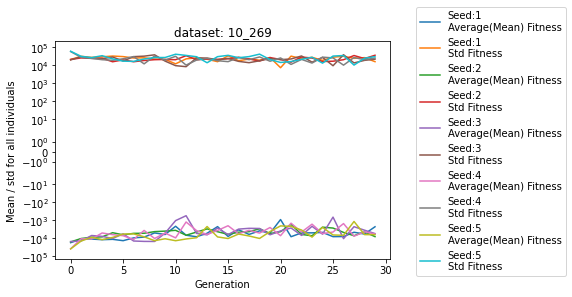

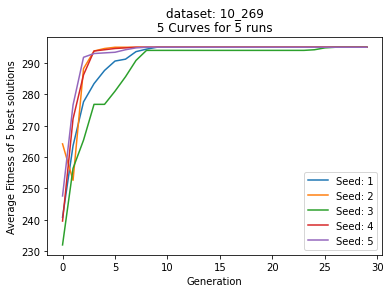

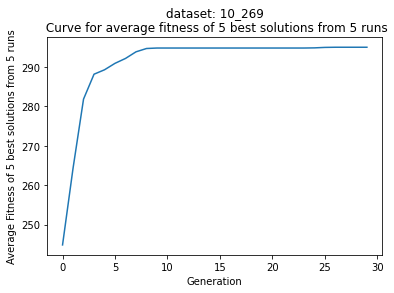


Best individual for seed 1:              
	 [0, 1, 1, 1, 0, 0, 0, 1, 1, 1]              
	 Fitness: 295.0              
	 Value: 295.0              
	 Weight: 269.0

Best individual for seed 2:              
	 [0, 1, 1, 1, 0, 0, 0, 1, 1, 1]              
	 Fitness: 295.0              
	 Value: 295.0              
	 Weight: 269.0

Best individual for seed 3:              
	 [0, 1, 1, 1, 0, 0, 0, 1, 1, 1]              
	 Fitness: 295.0              
	 Value: 295.0              
	 Weight: 269.0

Best individual for seed 4:              
	 [0, 1, 1, 1, 0, 0, 0, 1, 1, 1]              
	 Fitness: 295.0              
	 Value: 295.0              
	 Weight: 269.0

Best individual for seed 5:              
	 [0, 1, 1, 1, 0, 0, 0, 1, 1, 1]              
	 Fitness: 295.0              
	 Value: 295.0              
	 Weight: 269.0


In [129]:
ds_10_269 = Knapsack.constructFromFile('10_269')
run_5_times_with_different_seeds(ds_10_269,title="10_269",max_gen=30)

run each dataset individually with 5 different seed

- 10_269: with 10 items and bag capacity of 269. The optimal value is 295. 
- 23_10000: with 23 items and bag capacity of 10000. The optimal value is 9767.
- 100_995: with 100 items and bag capacity of 995. The optimal value is 1514

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Running GA with seed:  1
Best fitness:  9767.0
Best value:  9767.0
Best weight:  9768.0
Best chromosome:  [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
FOllowing are the statistics for each generation with the seed:  1
--------------------------------------------------------------------------------
gen	avg               	std               	min                	max    	best_ind_value	best_ind_weight	best_5_avg_fitness	best_ind_chromosome                                                  
0  	[-701029.2016]    	[1080582.70507192]	[-5546885.46]      	[9732.]	9732          	9733           	9719.4            	[0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
1  	[-282658.58180571]	[710739.39574434] 	[-4187362.67326733]	[9732.]	9732          	9733           	9718.8            	[0, 1, 0, 1, 0

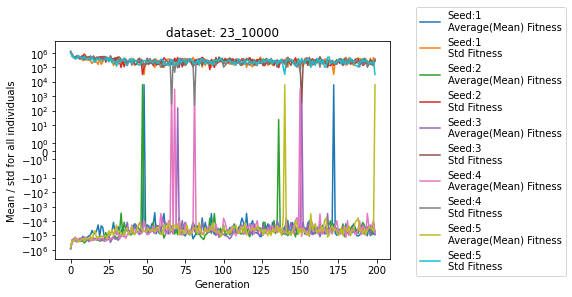

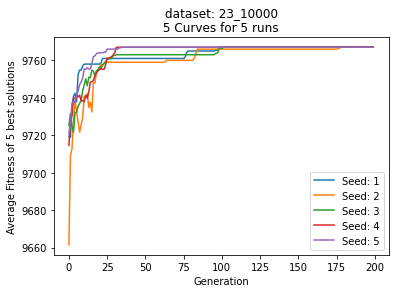

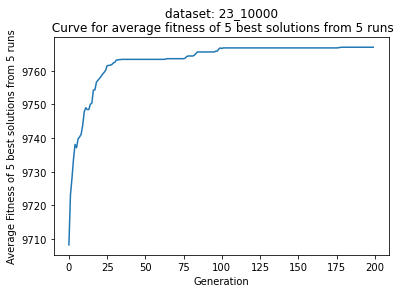


Best individual for seed 1:              
	 [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]              
	 Fitness: 9767.0              
	 Value: 9767.0              
	 Weight: 9768.0

Best individual for seed 2:              
	 [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]              
	 Fitness: 9767.0              
	 Value: 9767.0              
	 Weight: 9768.0

Best individual for seed 3:              
	 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]              
	 Fitness: 9767.0              
	 Value: 9767.0              
	 Weight: 9768.0

Best individual for seed 4:              
	 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]              
	 Fitness: 9767.0              
	 Value: 9767.0              
	 Weight: 9768.0

Best individual for seed 5:              
	 [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]              
	 Fitness: 9767.0              
	 Value

In [130]:
ds_23_10000 = Knapsack.constructFromFile("23_10000")
run_5_times_with_different_seeds(ds_23_10000,title="23_10000",max_gen=200)

run each dataset individually with 5 different seed

- 10_269: with 10 items and bag capacity of 269. The optimal value is 295. 
- 23_10000: with 23 items and bag capacity of 10000. The optimal value is 9767.
- 100_995: with 100 items and bag capacity of 995. The optimal value is 1514

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Running GA with seed:  1
Best fitness:  1234.0
Best value:  1234.0
Best weight:  982.0
Best chromosome:  [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
FOllowing are the statistics for each generation with the seed:  1
--------------------------------------------------------------------------------
gen	avg                 	std               	min                	max         	best_ind_value	best_ind_weight	best_5_avg_fitness	best_ind_chromosome                                                                                                                                          

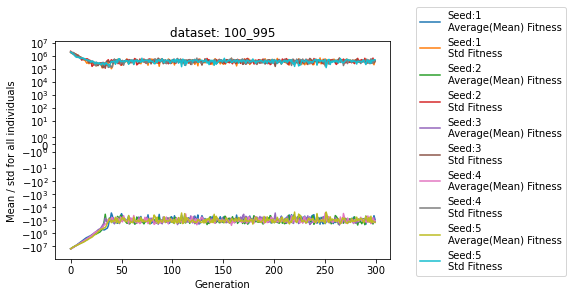

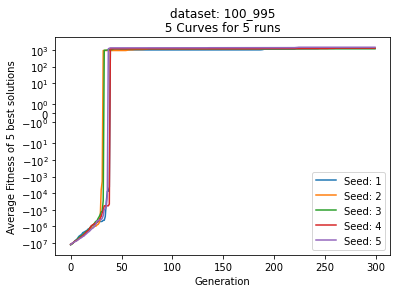

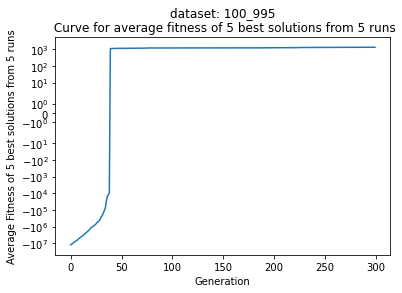


Best individual for seed 1:              
	 [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]              
	 Fitness: 1234.0              
	 Value: 1234.0              
	 Weight: 982.0

Best individual for seed 2:              
	 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]              
	 Fitness: 1344.0              
	 Value: 1344.0              
	 Weight: 959.0

Best individual for seed 3:              
	 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [8]:
# assert not True
ds_100_995 = Knapsack.constructFromFile("100_995")
run_5_times_with_different_seeds(ds_100_995,title="100_995",max_gen=300)


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# x = [i for i in range(82)]
# y = [-11834230.8, -10695814.2, -9663970.6, -9299741.4, -7741319.6, -6865892.8, -6368717.0, -5624669.2, -5218555.0, -4755818.0, -4452826.4, -4375443.6, -4063084.0, -3790982.8, -3597894.2, -3285662.8, -2974685.0, -2794586.4, -2373475.6, -2284516.8, -2206556.0, -1977245.2, -1751120.0, -1751120.0, -1488344.8, -1352164.0, -1207167.6, -1091871.4, -1066321.8, -989673.0, -989157.4, -988641.8, -961545.4, -859347.0, -846837.8, -765180.8, -713878.4, -672539.0, -627346.4, -532693.4, -375412.2, -296868.2, -206607.2, -36322.0, -17455.495049504952, 925.4, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0, 926.0,1000,9999]

# # sns.lineplot(x[0:50],y[0:50])
# # sns.lineplot(x[50:],y[50:])
# # plt.plot(x[0:50],y[0:50])
# # plt.plot(x[50:],y[50:])
# plt.plot(x,y)
# plt.yscale('symlog')
# # plt.xticks(y_pos, bars)
# plt.show()


run each dataset individually with 5 different seed

- 10_269: with 10 items and bag capacity of 269. The optimal value is 295. 
- 23_10000: with 23 items and bag capacity of 10000. The optimal value is 9767.
- 100_995: with 100 items and bag capacity of 995. The optimal value is 1514